In [146]:
import numpy as np
import pandas as pd
import os
import datetime
import random 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, CyclicLR,StepLR,MultiStepLR,ReduceLROnPlateau
from torch.utils.data import DataLoader,Dataset,random_split

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [7]:
train=pd.read_csv("playground-series-s4e5/train.csv",index_col='id')
test=pd.read_csv("playground-series-s4e5/test.csv",index_col='id')
train.head(10).T

id,0,1,2,3,4,5,6,7,8,9
MonsoonIntensity,5.000,6.00,6.00,3.000,5.000,5.00,8.00,6.000,5.000,4.000
TopographyDrainage,8.000,7.00,5.00,4.000,3.000,4.00,3.00,6.000,2.000,2.000
RiverManagement,5.000,4.00,6.00,6.000,2.000,1.00,1.00,5.000,8.000,3.000
Deforestation,8.000,4.00,7.00,5.000,6.000,4.00,2.00,7.000,5.000,5.000
Urbanization,6.000,8.00,3.00,4.000,4.000,2.00,3.00,5.000,4.000,8.000
ClimateChange,4.000,8.00,7.00,8.000,4.000,4.00,7.00,5.000,5.000,6.000
DamsQuality,4.000,3.00,1.00,4.000,3.000,6.00,3.00,3.000,2.000,5.000
Siltation,3.000,5.00,5.00,7.000,3.000,6.00,4.00,5.000,4.000,5.000
AgriculturalPractices,3.000,4.00,4.00,6.000,3.000,7.00,6.00,5.000,5.000,7.000
Encroachments,4.000,6.00,5.00,8.000,3.000,5.00,7.00,5.000,5.000,6.000


In [8]:
TARGET=train.columns[-1]
TARGET

'FloodProbability'

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
Encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


In [10]:
# corr_matrix=train.corr()
# plt.figure(figsize=(12,12))
# sns.set_theme(font_scale=0.6)
# sns.heatmap(data=corr_matrix,annot=True,vmax=0.0,center=-0.017,fmt=".3f",cbar=True,mask=np.triu(corr_matrix))
# plt.show()

In [11]:
# corr_matrix.min().min()

In [57]:
class StepByStep(object):

    def __init__(self,model,loss_fn,optimizer):
        # arguments as attributes
        self.model=model
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.device='cuda:0' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        # data loaders and lr schedulers
        self.train_loader=None
        self.val_loader=None
        self.scheduler=None
        self.is_batch_lr_scheduler=False


        # internally computed attributes
        self.losses=[]
        self.val_losses=[]
        self.scores=[]
        self.val_scores=[]
        self.learning_rates=[]
        self.total_epochs=0

        # creates train step function for our model
        self.train_step_fn=self._make_train_step_fn()
        # creates validation step function
        self.val_step_fn=self._make_val_step_fn()


    def r2_score(self,y_true, y_pred):
        SS_res = torch.sum((y_true - y_pred) ** 2)
        SS_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        return 1 - SS_res / SS_tot

    def to(self,device):
        try:
            device=self.device
            self.model.to(device)
        except AssertionError or RuntimeError:
            self.device='cuda:0' if torch.cuda.is_available() else 'cpu'
            self.model.to(self.device)
            print(f"Couldn't send model to {device}, sent it to CPU")
    

    def set_loaders(self,train_loader,val_loader=None):
        self.train_loader=train_loader
        self.val_loader=val_loader


    
    
    def _make_train_step_fn(self):
        # Build a function that will perform a step in train loop
        def perform_train_step_fn(x,y):
            # set model to train mode
            self.model.train()
            # forward pass
            yhat=self.model(x)
            # compute the loss
            loss=self.loss_fn(yhat,y)
            # compute gradients
            loss.backward()
            # update parameters
            self.optimizer.step()
            self.optimizer.zero_grad()
            # compute score
            score=self.r2_score(y,yhat)
            # return loss and score
            return loss.item(),score.item()
        # Return the function that will be called inside train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Build a function that will perform a step in the validation loop
        def perform_val_step_fn(x,y):
            # set model to eval mode
            self.model.eval()
            # forward pass
            yhat=self.model(x)
            # compute the loss
            loss=self.loss_fn(yhat,y)
            # compute r2 score
            val_score=self.r2_score(y,yhat)
            return loss.item(),val_score.item()
        return perform_val_step_fn
    
    def _mini_batch(self,validation=False):
        if validation:
            data_loader=self.val_loader
            step_fn=self.val_step_fn
        else:
            data_loader=self.train_loader
            step_fn=self.train_step_fn

        if data_loader is None:
            return None
        
        n_batches=len(data_loader)

        # mini batch loop
        mini_batch_losses=[]
        mini_batch_scores=[]
        for i,(x_batch,y_batch) in enumerate(data_loader):
            x_batch=x_batch.to(self.device)
            y_batch=y_batch.to(self.device)
            mini_batch_loss,mini_batch_score=step_fn(x_batch,y_batch)
            mini_batch_scores.append(mini_batch_score)
            mini_batch_losses.append(mini_batch_loss)
        
        loss=np.mean(mini_batch_losses)
        score=np.mean(mini_batch_scores)
        return loss,score

    # set a random seed for reproducibility
    def set_seed(self,seed=42):
        torch.backends.cudnn.deterministic=True
        torch.backends.cudnn.benchmark=False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self,n_epochs,seed=42):
        # ensure reproducibilty of the training process
        self.set_seed(seed)
    
        for epoch in tqdm(range(n_epochs)):
            self.total_epochs+=1
            # perform training using mini batches
            loss,score=self._mini_batch(validation=False)
            self.losses.append(loss)
            self.scores.append(score)

            # perform validation
            with torch.no_grad():
                val_loss,val_score=self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
                self.val_scores.append(val_score)


    def predict(self,x):
        # set model to eval mode
        self.model.eval()
        # take numpy array and make it a floar tensor
        x_tensor=torch.as_tensor(x,dtype=torch.float32)
        # send tensor to device
        x_tensor=x_tensor.to(self.device)
        # make prediction
        with torch.no_grad():
            yhat_tensor=self.model(x_tensor)
        # set model to train model after prediction
        self.model.train()
        # detach prediction tensor and send to cpu
        return yhat_tensor.detach().cpu().numpy()
    

    def plot_losses(self):
        plt.figure(figsize=(10,4))
        plt.plot(self.losses,label='Training Loss',c='b')
        plt.plot(self.val_losses,label='Validation Loss',c='r')
        plt.yscale('log')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.tight_layout()
        plt.show()

    def plot_scores(self):
        plt.figure(figsize=(10,4))
        plt.plot(self.scores,label='Training score',c='b')
        plt.plot(self.val_scores,label='Validation score',c='r')
        plt.legend()
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('R2 Score')
        plt.tight_layout()
        plt.show()

    def count_parameters(self):
        pass




In [58]:
# def r2_score(y_true, y_pred):
#     SS_res = torch.sum((y_true - y_pred) ** 2)
#     SS_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
#     return 1 - SS_res / SS_tot

# r2_score(torch.as_tensor([2,3,4,5]).float(),torch.as_tensor([2.1,2.9,4.2,4.8]).float()).item()

In [59]:
# Create a custom dataset
class TabularData(Dataset):
    def __init__(self,X_tensor,y_tensor):
        self.X=X_tensor
        self.y=y_tensor

    def __getitem__(self, index):
        return self.X[index],self.y[index]
    
    def __len__(self):
        return len(self.X)

In [165]:
# Data preparation
X=train.drop(labels=[TARGET],axis=1)
y=train[TARGET]
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

# # standardize features
# sc=StandardScaler()
# X_train=sc.fit_transform(X_train)
# X_val=sc.transform(X_val)

# Prepare tensors
X_train_tensor=torch.as_tensor(X_train.values,dtype=torch.float32)
y_train_tensor=torch.as_tensor(y_train.values.reshape(-1,1),dtype=torch.float32)
X_val_tensor=torch.as_tensor(X_val.values,dtype=torch.float32)
y_val_tensor=torch.as_tensor(y_val.values.reshape(-1,1),dtype=torch.float32)

# create train dataset
train_dataset=TabularData(X_train_tensor,y_train_tensor)
val_dataset=TabularData(X_val_tensor,y_val_tensor)
# create dataloaders
train_loader=DataLoader(dataset=train_dataset,
                        batch_size=640,
                        num_workers=8,
                        pin_memory=True,
                        shuffle=True)
val_loader=DataLoader(dataset=val_dataset,
                      batch_size=640,
                      num_workers=8,
                      pin_memory=True,
                      )


In [166]:
class MyModel(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(MyModel, self).__init__()
        
        self.regressor = nn.Sequential(
            
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(384, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, output_shape)
        )
    
    def forward(self, x):
        return self.regressor(x)


In [167]:
# model config
model=MyModel(input_shape=train.shape[1]-1,output_shape=1)
optimizer=optim.Adam(model.parameters(),lr=0.01)
loss_fn=nn.MSELoss(reduction='mean')

In [168]:
stepbystep=StepByStep(model,loss_fn,optimizer)
stepbystep.set_loaders(train_loader,val_loader)
stepbystep.train(15)


  0%|          | 0/15 [00:00<?, ?it/s]

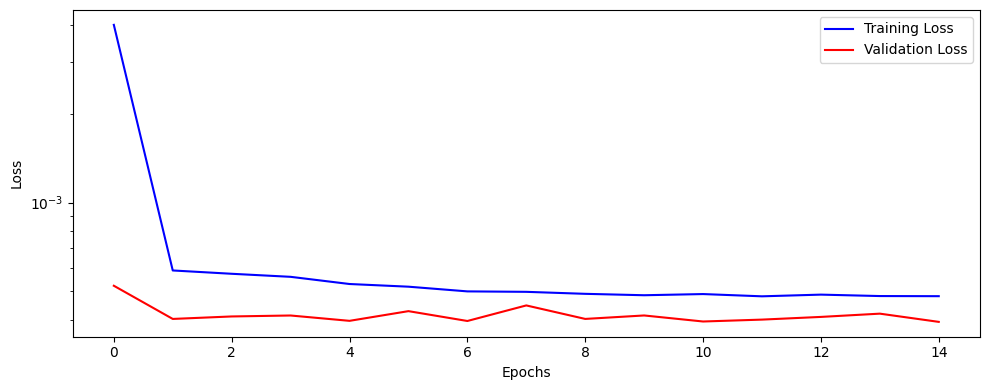

In [169]:
stepbystep.plot_losses()

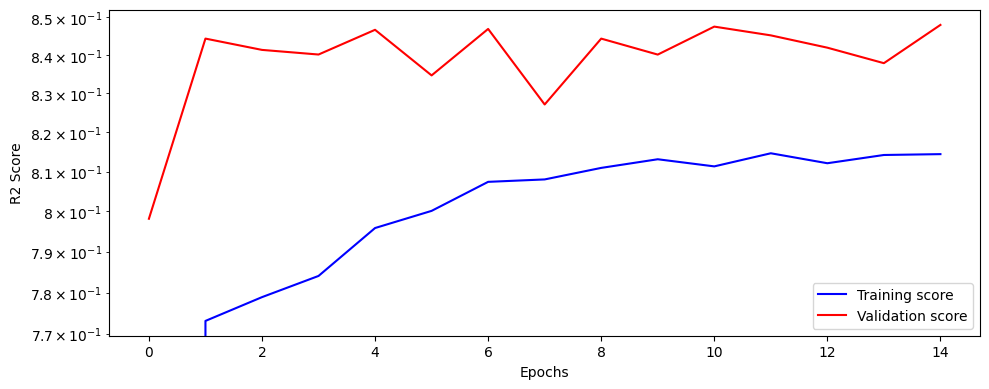

In [170]:
stepbystep.plot_scores()

In [171]:
stepbystep.val_scores

[0.7981754679339272,
 0.8443390761102949,
 0.8413663503101894,
 0.8401519410950797,
 0.8466587506021772,
 0.8346961878027235,
 0.8468852709020888,
 0.8271553679874966,
 0.8443350761277335,
 0.8401359278815134,
 0.8475022852420807,
 0.8451880359649658,
 0.8419496595859528,
 0.8378871524333954,
 0.8479493618011474]

In [173]:
stepbystep.r2_score(y_val_tensor,torch.as_tensor(stepbystep.predict(X_val.values),dtype=torch.float32)).item()

0.8484658598899841

.8570876121520996

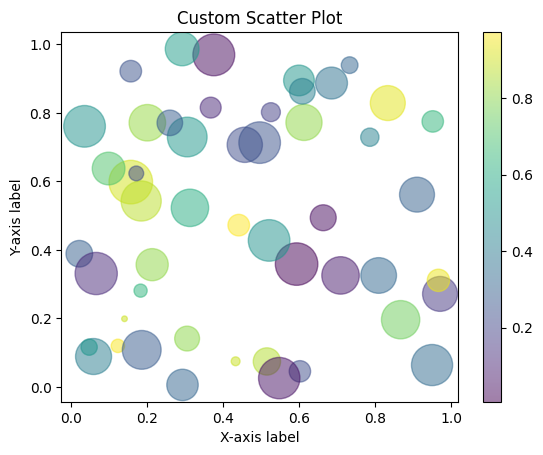

In [177]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.random.rand(50)
y = np.random.rand(50)

# Customizing colors, transparency (alpha) and scatter size (s)
colors = np.random.rand(50)  # Array of colors
sizes = 1000 * np.random.rand(50)  # Array of sizes

plt.scatter(x, y, c=colors, s=sizes, alpha=0.5)

# Customizing the plot further with title and labels
plt.title('Custom Scatter Plot')
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')

# Show color scale
plt.colorbar()

plt.show()